In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from scipy.stats import pearsonr
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.preprocessing import MinMaxScaler

/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_78475/1086319364.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(j, i, s=size, c=color, alpha=alpha)
/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_78475/1086319364.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 调整主轴的布局，为colorbar和图例留出空间


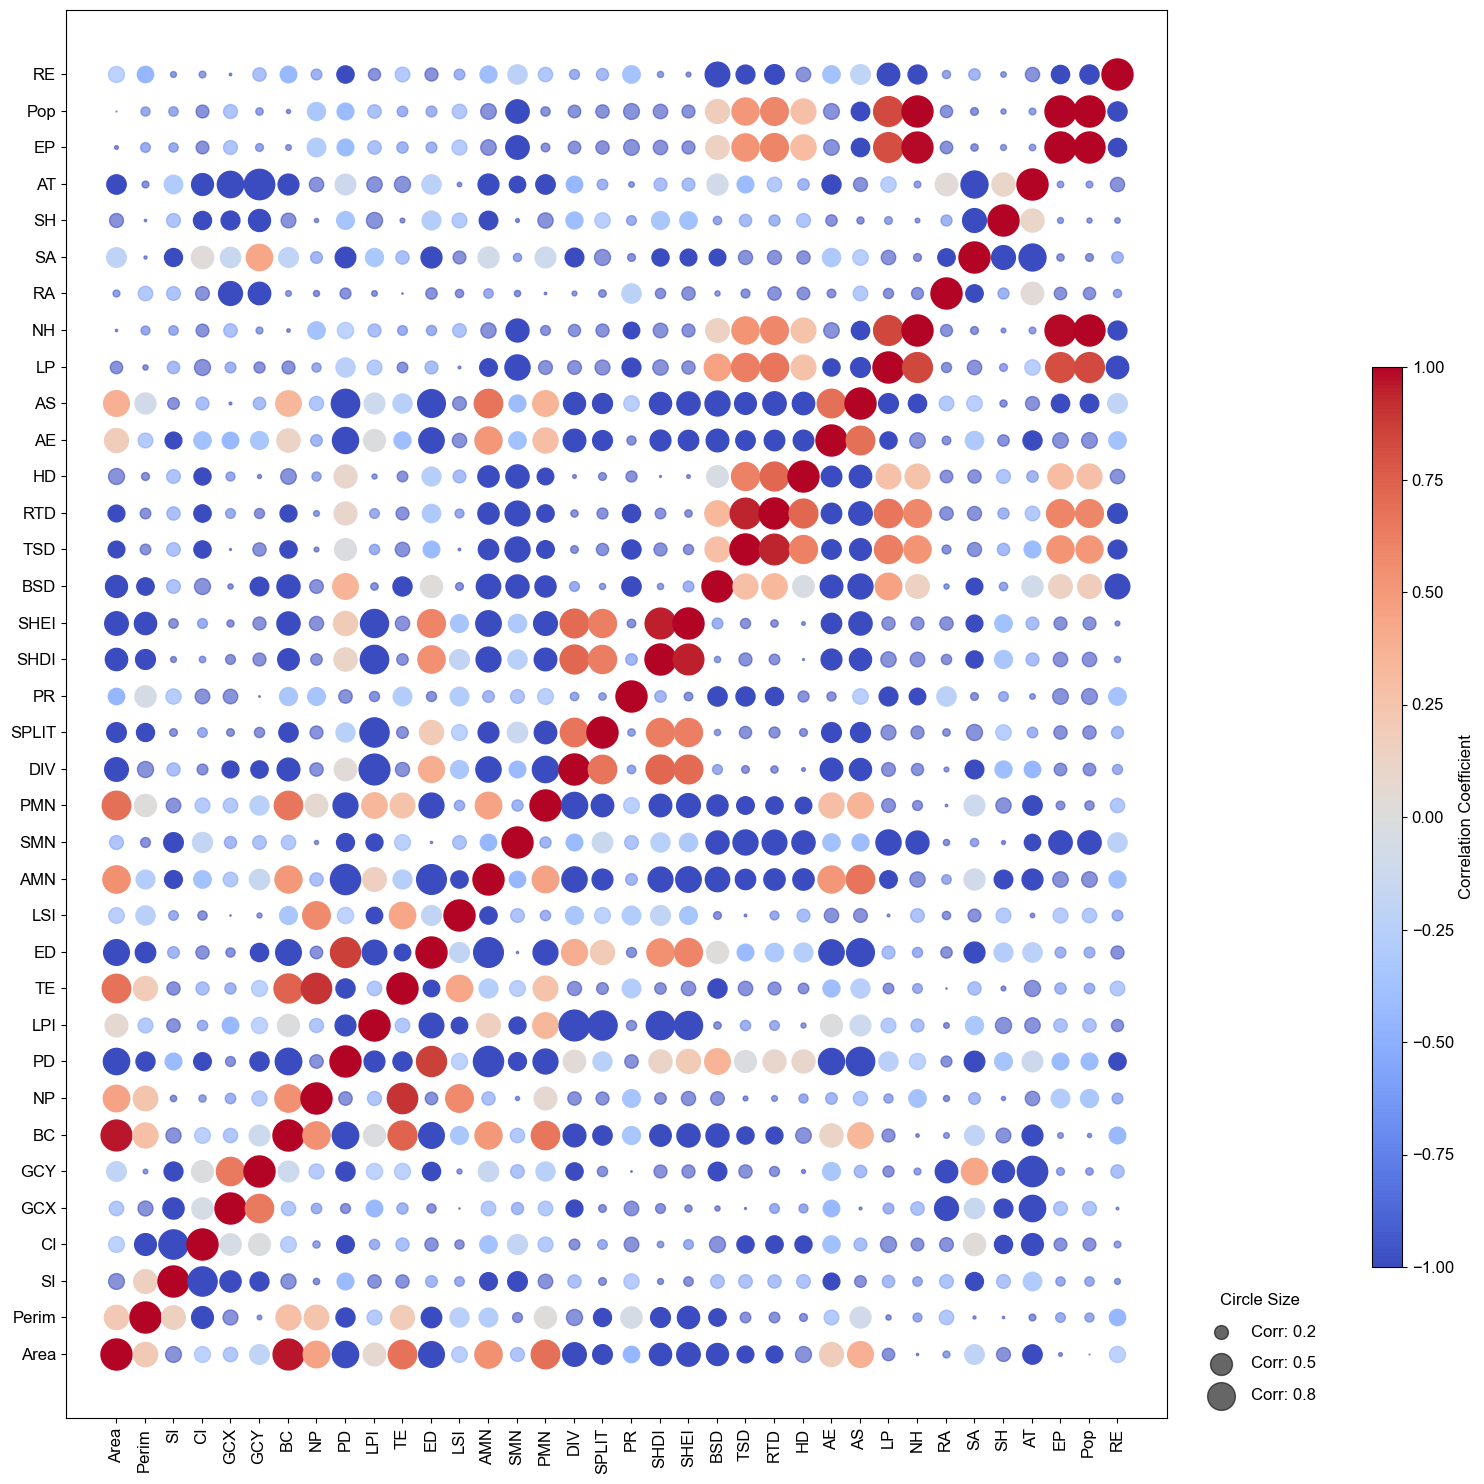

In [2]:
file_path = 'Analysis_data_0117.xlsx'

# 读取数据
df = pd.read_excel(file_path, sheet_name='Figurenew', nrows=51)
df = df.set_index('cityname')

# 分离自变量和因变量
X = df.iloc[:, :-1]  # 所有列除了最后一列
y = df.iloc[:, -1]   # 最后一列

# 计算相关性矩阵和 P 值矩阵
correlation_matrix = X.corr()
p_values_matrix = pd.DataFrame(data=np.zeros(shape=(X.shape[1], X.shape[1])), columns=X.columns, index=X.columns)

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['text.color'] = 'black'



for col1 in X.columns:
    for col2 in X.columns:
        if col1 != col2:
            corr, p_value = pearsonr(X[col1], X[col2])
            p_values_matrix.loc[col1, col2] = p_value

# 定义图表的大小
fig, ax = plt.subplots(figsize=(15, 15))

# 最大圆圈大小和最小透明度设置
max_circle_size = 500
min_alpha = 0.6

# 遍历相关性矩阵的每个元素来绘制圆圈
for i, col1 in enumerate(X.columns):
    for j, col2 in enumerate(X.columns):
        size = np.abs(correlation_matrix.at[col1, col2]) * max_circle_size
        alpha = 1.0 if p_values_matrix.at[col1, col2] < 0.05 else min_alpha
        color = plt.get_cmap('coolwarm')(correlation_matrix.at[col1, col2])
        ax.scatter(j, i, s=size, c=color, alpha=alpha)
# 添加色阶
norm = Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
# 设置色阶的位置和高度
cbar_ax_height = 0.7 * fig.get_figheight() / fig.get_dpi()  # 色阶的高度为图表高度的70%
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.6])  # 调整为合适的位置和大小
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Correlation Coefficient')

# 添加圆圈大小的图例
legend_sizes = [0.2, 0.5, 0.8]
legend_labels = [f'Corr: {size}' for size in legend_sizes]
handles = [plt.scatter([], [], s=size * max_circle_size, c='black', alpha=0.6) for size in legend_sizes]
legend = ax.legend(handles, legend_labels, loc='lower left', bbox_to_anchor=(1.02, 0.0), title='Circle Size', frameon=False, labelspacing=1)
# 设置坐标轴的标签
ax.set_xticks(range(len(X.columns)))
ax.set_yticks(range(len(X.columns)))
ax.set_xticklabels(X.columns, rotation=90)
ax.set_yticklabels(X.columns)

# 显示图表
plt.tight_layout(rect=[0, 0, 0.9, 1])  # 调整主轴的布局，为colorbar和图例留出空间

plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Train,Test
0,R2,0.866542,0.657162
1,RMSE,32.207545,56.474007
2,MAE,25.940229,43.303025


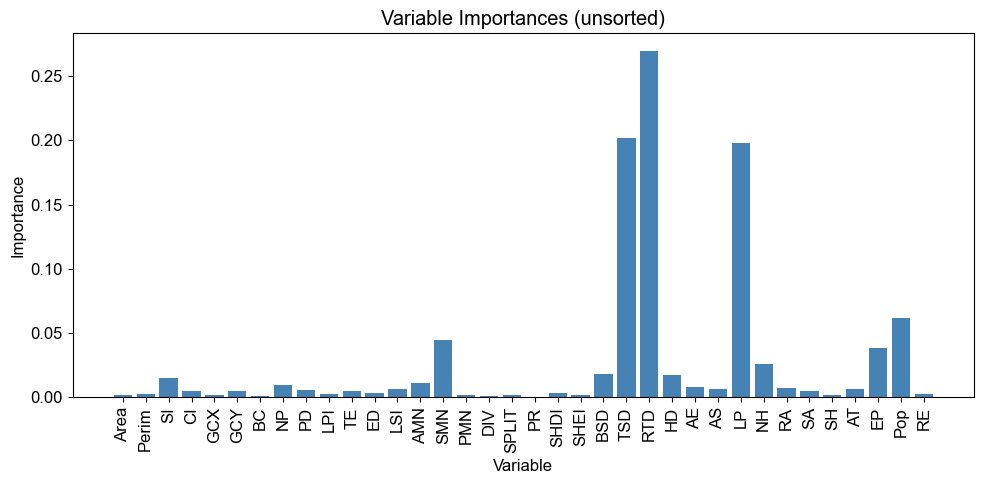

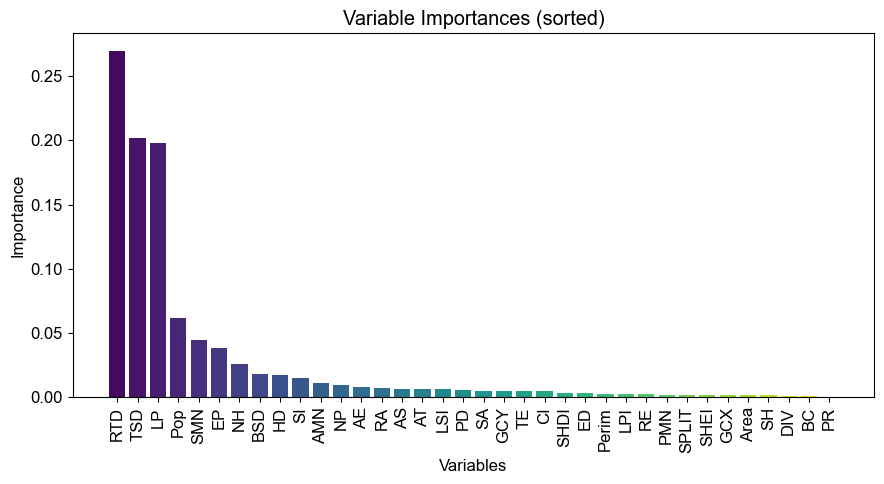

Best hyper-parameters : {'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 200}
CV RMSE (mean ± SD) : 49.33 ± 14.10


In [3]:
# ------------------------------------------------------------------
# 2. 训练/测试划分 + GridSearchCV
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22
)

param_grid = {
    "n_estimators":     [100, 200, 500],
    "max_depth":        [3, 5, 7, None],
    "max_features":     ["sqrt", 0.5, None],
    "min_samples_leaf": [1, 2, 4],
}

cv_inner = KFold(n_splits=5, shuffle=True, random_state=0)

rf_base  = RandomForestRegressor(random_state=0)
grid     = GridSearchCV(
    rf_base,
    param_grid,
    cv=cv_inner,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=0,
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

# ------------------------------------------------------------------
# 3. 过拟合检查：性能指标
# ------------------------------------------------------------------
train_pred = best_rf.predict(X_train)
test_pred  = best_rf.predict(X_test)

metrics = pd.DataFrame({
    "Metric": ["R2", "RMSE", "MAE"],
    "Train": [
        r2_score(y_train, train_pred),
        mean_squared_error(y_train, train_pred, squared=False),  # RMSE
        mean_absolute_error(y_train, train_pred),                # MAE
    ],
    "Test": [
        r2_score(y_test, test_pred),
        mean_squared_error(y_test, test_pred, squared=False),    # RMSE
        mean_absolute_error(y_test, test_pred),                   # MAE
    ],
})

display(metrics)
# ------------------------------------------------------------------
# 4. 变量重要性可视化（两张图，保留原格式）
# ------------------------------------------------------------------
importances   = best_rf.feature_importances_
feature_list  = X.columns.tolist()
x_positions   = range(len(importances))

# unsorted bar chart ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(x_positions, importances, color="steelblue")
plt.xticks(x_positions, feature_list, rotation="vertical")
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importances (unsorted)")
plt.tight_layout()
plt.show()

# sorted bar chart --------------------------------------------------
sorted_idx  = np.argsort(importances)[::-1]
colors      = sns.color_palette("viridis", len(importances))

plt.figure(figsize=(9, 5))
plt.bar(range(len(importances)), importances[sorted_idx], color=colors)
plt.xticks(range(len(importances)),
           [feature_list[i] for i in sorted_idx],
           rotation="vertical")
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.title("Variable Importances (sorted)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. 打印最佳参数与交叉验证 RMSE
# ------------------------------------------------------------------
cv_rmse_mean = -grid.best_score_
cv_rmse_std  = grid.cv_results_["std_test_score"][grid.best_index_]

print("Best hyper-parameters :", grid.best_params_)
print(f"CV RMSE (mean ± SD) : {cv_rmse_mean:.2f} ± {cv_rmse_std:.2f}")


Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Train R² = 0.9303053756392572
Test  R² = 0.6888891913676147


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

      Var1 Var2  ΔRMSE_inter
555    RTD   LP    10.656530
464  SPLIT  RTD     8.119281
407    SMN  RTD     8.040249
186    GCY   LP     7.409357
566     HD   LP     7.011388
595     LP   RA     6.877309
431    PMN   LP     6.847404
450    DIV   LP     6.074087
556    RTD   NH     5.722347
446    DIV  RTD     5.463505
526    BSD  RTD     5.278139
594     LP   NH     5.128193
596     LP   SA     5.101570
541    TSD   AE     4.921369
292    LPI  RTD     4.739483
121     CI  RTD     4.565794
543    TSD   LP     4.400819
60   Perim   LP     4.394834
485     PR   LP     4.239819
512   SHEI  RTD     4.137824
156    GCX   LP     3.993903
552    RTD   HD     3.972505
341     ED  RTD     3.660873
406    SMN  TSD     3.637432
125     CI   LP     3.457193
427    PMN  RTD     3.387520
480     PR  TSD     3.320807
22    Area  RTD     3.092730
562    RTD  Pop     3.087438
270     PD   LP     2.976805
563    RTD   RE     2.953017
411    SMN   LP     2.754492
26    Area   LP     2.684164
511   SHEI  TS

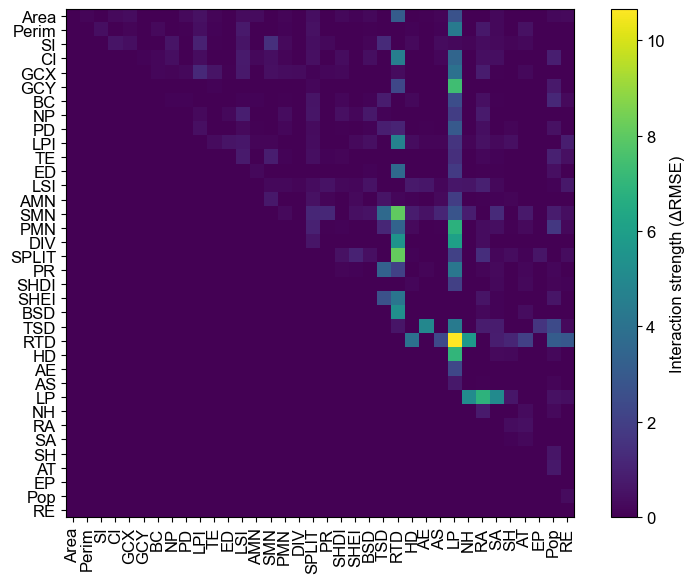

In [4]:
"""
RF + permutation-based pairwise interaction
Author : Liqiao 
"""

X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=22)

# ───────────────── 2. 调参 ─────────────────
grid = {
    "n_estimators":[200,500],
    "max_depth":[None,7],
    "max_features":["sqrt",0.5],
    "min_samples_leaf":[1,2],
}
cv = KFold(5, shuffle=True, random_state=0)
best_rf = GridSearchCV(RandomForestRegressor(random_state=0), grid,
                       cv=cv, n_jobs=-1,
                       scoring="neg_root_mean_squared_error").fit(X_tr, y_tr).best_estimator_

print("Best params:", best_rf.get_params())
print("Train R² =", r2_score(y_tr, best_rf.predict(X_tr)))
print("Test  R² =", r2_score(y_te, best_rf.predict(X_te)))

# ───────────────── 3. permutation-based 交互 ─────────────────
base_rmse = mean_squared_error(y, best_rf.predict(X), squared=False)
rng = np.random.default_rng(0)

# (1) 单变量 permutation 损失增量
delta_single = {}
for col in X:
    Xp = X.copy()
    Xp[col] = rng.permutation(Xp[col].values)
    delta_single[col] = mean_squared_error(
        y, best_rf.predict(Xp), squared=False) - base_rmse

# (2) 成对 permutation → 交互强度
p = X.shape[1]
inter_mat = np.zeros((p, p))
cols = X.columns.tolist()

for i in range(p):
    for j in range(i+1, p):
        Xp = X.copy()
        Xp[cols[i]] = rng.permutation(Xp[cols[i]].values)
        Xp[cols[j]] = rng.permutation(Xp[cols[j]].values)
        delta_pair = mean_squared_error(y, best_rf.predict(Xp), squared=False) - base_rmse
        inter_mat[i, j] = max(delta_pair - delta_single[cols[i]] - delta_single[cols[j]], 0)

# ───────────────── 4. Top-10 & 保存 ─────────────────
pairs = [(cols[i], cols[j], inter_mat[i, j])
         for i in range(p) for j in range(i+1, p)]
top10 = (pd.DataFrame(pairs, columns=["Var1","Var2","ΔRMSE_inter"])
           .sort_values("ΔRMSE_inter", ascending=False)
           .head(50))
top10.to_excel("top10_interactions.xlsx", index=False)
print(top10)

# ───────────────── 5. Heatmap ─────────────────
plt.figure(figsize=(8,6))
plt.imshow(inter_mat)            # 默认 cmap
plt.colorbar(label="Interaction strength (ΔRMSE)")
plt.xticks(range(p), cols, rotation=90)
plt.yticks(range(p), cols)
plt.tight_layout()
plt.savefig("interaction_heatmap.png", dpi=300)
plt.show()


In [5]:
# 1. 计算 SHAP 交互值
explainer = shap.TreeExplainer(best_rf)
shap_int = explainer.shap_interaction_values(X_train)
# shap_int.shape == (n_samples, n_features, n_features)

# 2. 求取对角线以外的 mean(|interaction|) 
#    axis=0 后得到 (n_features, n_features) 的矩阵
mean_abs_int = np.mean(np.abs(shap_int), axis=0)

# 3. 构建所有特征对及其交互强度列表
feature_names = X_train.columns.tolist()
pairs = []
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        pairs.append({
            'feature_i': feature_names[i],
            'feature_j': feature_names[j],
            'mean_abs_interaction': mean_abs_int[i, j]
        })

# 4. 排序并取 top k
df_pairs = pd.DataFrame(pairs)
df_topk = df_pairs.sort_values('mean_abs_interaction', ascending=False).head(40)
df_topk

,feature_i,feature_j,mean_abs_interaction
555,RTD,LP,0.624462
543,TSD,LP,0.456145
292,LPI,RTD,0.398336
181,GCY,TSD,0.387565
406,SMN,TSD,0.322051
557,RTD,RA,0.309252
539,TSD,RTD,0.306488
464,SPLIT,RTD,0.291052
595,LP,RA,0.275987
182,GCY,RTD,0.275413


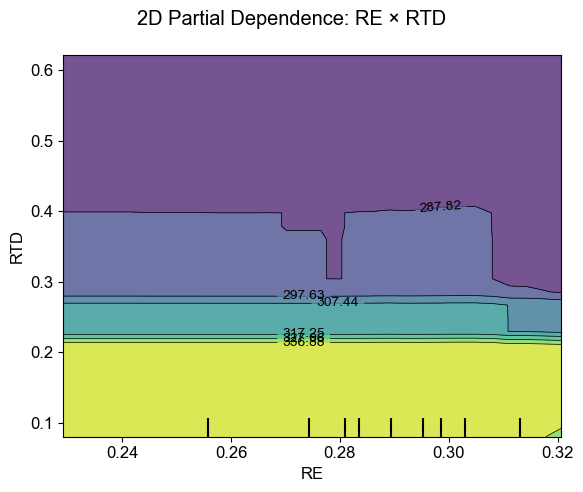

In [6]:
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    max_features=0.5,
    min_samples_leaf=2,
    random_state=0
)
best_rf.fit(X_train, y_train)

# 4. 绘制 RE × RTD 的 2D PDP（仅平均效应）
disp = PartialDependenceDisplay.from_estimator(
    best_rf,
    X_train,
    features=[("RE", "RTD")],
    kind="average",
    grid_resolution=30
)
# 调整图大小
disp.figure_.set_size_inches(6, 5)
plt.suptitle("2D Partial Dependence: RE × RTD")
plt.tight_layout()
plt.show()

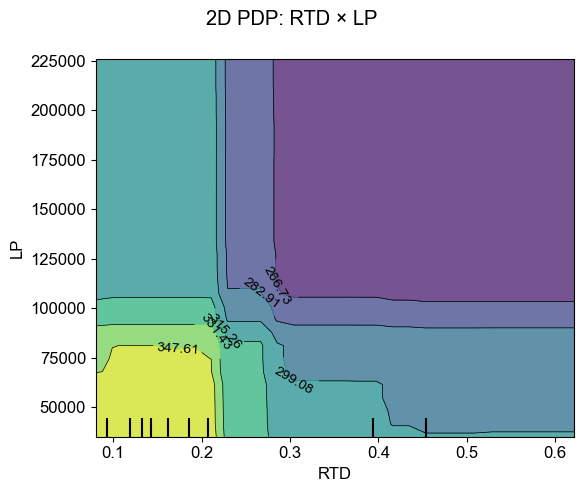

In [7]:
# from sklearn.inspection import PartialDependenceDisplay

#  RTD & LP 
disp = PartialDependenceDisplay.from_estimator(
    best_rf,
    X_train,
    features=[('RTD','LP')],
    kind='average',
    grid_resolution=30
)
disp.figure_.suptitle('2D PDP: RTD × LP')
disp.figure_.set_size_inches(6,5)
plt.tight_layout(); plt.show()

/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_78475/319192155.py:66: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


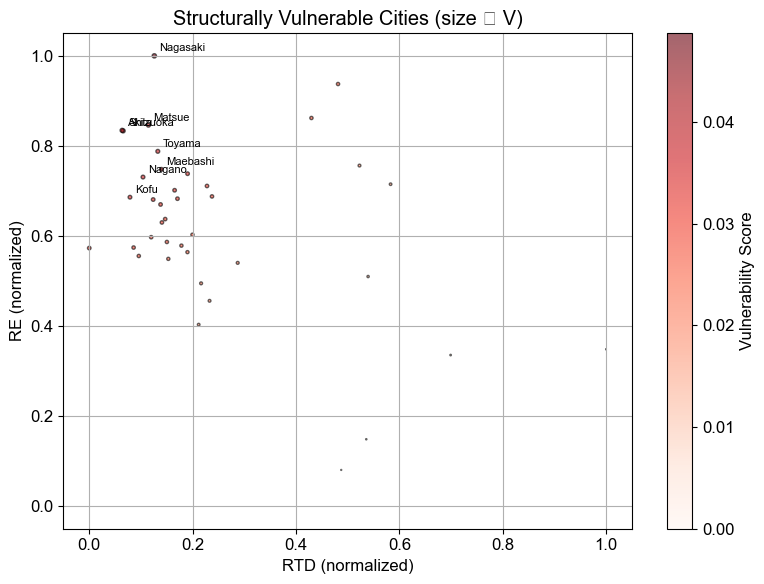

Top 10 Structurally Vulnerable Cities:
                RE       RTD  Vulnerability
city                                       
Nagasaki  0.331355  0.126166       0.048692
Akita     0.312394  0.079722       0.043530
Shizuoka  0.312266  0.081159       0.043382
Matsue    0.313725  0.117686       0.041736
Toyama    0.307060  0.131205       0.038072
Nagano    0.300515  0.109830       0.036479
Maebashi  0.302480  0.136390       0.035852
Kofu      0.295386  0.091012       0.035210
Tsu       0.301368  0.174162       0.033304
Miyazaki  0.294792  0.124523       0.033240


In [8]:
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    max_features=0.5,
    min_samples_leaf=2,
    random_state=0
)
best_rf.fit(X_train, y_train)

#  SHAP  w(RE, RTD)
explainer = shap.TreeExplainer(best_rf)
shap_interactions = explainer.shap_interaction_values(X_train)  # (n_samples, n_feat, n_feat)
mean_abs_int = np.mean(np.abs(shap_interactions), axis=0)
feat_names = X_train.columns.tolist()
i_re = feat_names.index("RE")
i_rtd = feat_names.index("RTD")
w = mean_abs_int[i_re, i_rtd]

# 5.  V = w * RE' * (1 - RTD')
scaler = MinMaxScaler()
RE_norm = scaler.fit_transform(X_train[["RE"]]).flatten()
RTD_norm = scaler.fit_transform(X_train[["RTD"]]).flatten()
V = w * RE_norm * (1 - RTD_norm)

# 6. Results
df_vul = pd.DataFrame({
    "city": X_train.index,
    "RE": X_train["RE"],
    "RTD": X_train["RTD"],
    "RE_norm": RE_norm,
    "RTD_norm": RTD_norm,
    "Vulnerability": V
}).set_index("city")

# 7. Recognize Vulnerable Cities
threshold = df_vul["Vulnerability"].quantile(0.8)
df_vul["StructurallyVulnerable"] = df_vul["Vulnerability"] >= threshold

# 8. Visualization
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(
    df_vul["RTD_norm"],
    df_vul["RE_norm"],
    s=df_vul["Vulnerability"]*200,  
    c=df_vul["Vulnerability"],
    cmap="Reds",
    alpha=0.6,
    edgecolor="k"
)
# colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Vulnerability Score")

for city, row in df_vul[df_vul["StructurallyVulnerable"]].iterrows():
    ax.text(
        row["RTD_norm"] + 0.01,
        row["RE_norm"] + 0.01,
        city,
        fontsize=8
    )

ax.set_xlabel("RTD (normalized)")
ax.set_ylabel("RE (normalized)")
ax.set_title("Structurally Vulnerable Cities (size ∝ V)")
ax.grid(True)
plt.tight_layout()
plt.show()
top_vul = df_vul.sort_values("Vulnerability", ascending=False).head(10)
print("Top 10 Structurally Vulnerable Cities:")
print(top_vul[["RE","RTD","Vulnerability"]])


In [9]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size']      = 11
plt.rcParams['text.color']     = 'black'

# ─────────────────── GridSearchCV (5-fold) ───────────────────
param_grid = {
    'n_estimators'     : [100, 200, 500],
    'max_depth'        : [3, 5, 7, None],
    'max_features'     : ['sqrt', 0.5, None],
    'min_samples_leaf' : [1, 2, 4]
}

inner_cv  = KFold(n_splits=5, shuffle=True, random_state=0)
rf_base   = RandomForestRegressor(random_state=0)

search = GridSearchCV(
    rf_base,
    param_grid,
    cv       = inner_cv,
    scoring  = 'neg_root_mean_squared_error',
    n_jobs   = -1,
    verbose  = 0
)
search.fit(X_train, y_train)

best_rf   = search.best_estimator_
print("➤ Best hyper-parameters:", search.best_params_)

cv_rmse_mean = -search.best_score_
cv_rmse_std  = search.cv_results_['std_test_score'][search.best_index_]
print(f"➤ 5-fold CV RMSE = {cv_rmse_mean:.2f} ± {cv_rmse_std:.2f}")

train_pred = best_rf.predict(X_train)
test_pred  = best_rf.predict(X_test)

print(f"➤ Train R² = {r2_score(y_train, train_pred):.3f}")
print(f"➤ Test  R² = {r2_score(y_test , test_pred ):.3f}")
print(f"➤ Test RMSE = {mean_squared_error(y_test, test_pred, squared=False):.2f}")
print(f"➤ Test MAE  = {mean_absolute_error(y_test, test_pred):.2f}")  # 修改点2：修正MAE计算

# ─────────────────── SHAP summary plot ───────────────────
print("Computing SHAP values …")
explainer   = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

# # a) Summary plot
# shap.summary_plot(shap_values, X_train, show=False)
# plt.savefig("shap_summary_plot.svg", format='svg', bbox_inches='tight')
# plt.close()
# Create the figure
plt.figure(figsize=(8, 10))

# Draw the summary plot with a custom cmap
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type="dot",       # the default
    color_bar=True,        # show color‐bar
    cmap="RdBu_r",         # red‐blue, low=blue, high=red
    show=False
)

plt.tight_layout()
plt.savefig("shap_summary_custom_cmap.svg", format="svg", bbox_inches="tight")
plt.close()

➤ Best hyper-parameters: {'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 200}
➤ 5-fold CV RMSE = 49.33 ± 14.10
➤ Train R² = 0.867
➤ Test  R² = 0.657
➤ Test RMSE = 56.47
➤ Test MAE  = 43.30
Computing SHAP values …


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# ─────────────────── 6. Partial-Dependence Plots ───────────────────
print("Drawing PDPs …")
topn = 30
fig, axs = plt.subplots(6, 5, figsize=(15, 15))
axs = axs.ravel()

for i, feat_idx in enumerate(np.argsort(best_rf.feature_importances_)[::-1][:topn]):
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train,
        [feat_idx],
        ax            = axs[i],
        feature_names = X_train.columns,
        grid_resolution = 50
    )

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("pdp_all.svg", format='svg', bbox_inches='tight')
plt.close()
print("✓ PDP figure → 'pdp.svg'")

Drawing PDPs …
✓ PDP figure → 'pdp.svg'


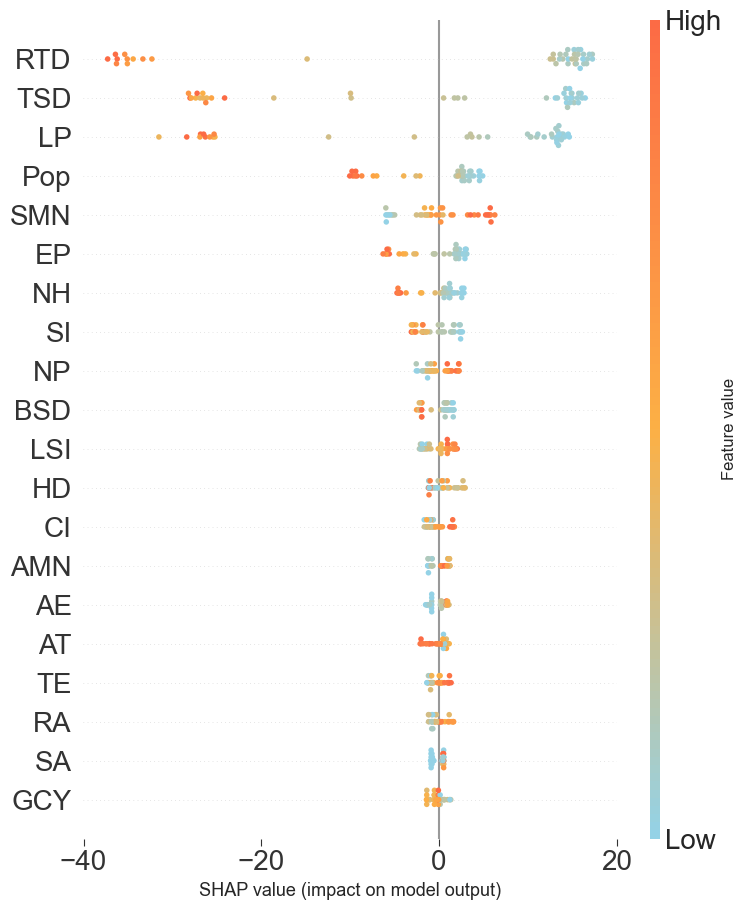

In [11]:
from matplotlib.colors import LinearSegmentedColormap

# ── 1. Matplotlib & Seaborn styling ──
plt.rcParams['font.family']     = 'Arial'
plt.rcParams['font.size']       = 20    # base font size
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['text.color']      = 'black'
# Use the “white” style (no grid or background boxes)
sns.set_style("white")

# ── 2. Custom colormap ──
colors     = ["#94d2e6", "#fcb045", "#fc6b45"]
custom_cmap = LinearSegmentedColormap.from_list('my_custom_cmap', colors, N=100)

# ── 3. Compute SHAP values ──
explainer   = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

# ── 4. Draw summary plot ──
plt.figure(figsize=(3, 5))
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="dot",
    cmap=custom_cmap,
    show=False
)

# ── 5. Tweak plot appearance ──
fig = plt.gcf()
axes = fig.axes

# Hide spines (the box lines) on the main dot‐plot axes
main_ax = axes[0]
for spine in main_ax.spines.values():
    spine.set_visible(False)

# Make sure ticks remain visible
main_ax.tick_params(axis='both', which='both', length=5)

# Enlarge tick labels
main_ax.tick_params(axis='both', labelsize=20)

# Colorbar: keep its outline if you like
cbar_ax = axes[-1]
cbar_ax.tick_params(axis='both', labelsize=20)
# Optionally, hide the colorbar frame too:
for spine in cbar_ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("shap_summary_clean.svg", dpi=300, format="svg", bbox_inches="tight")
plt.show()
plt.close()

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Best hyper-parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5, 'subsample': 0.6}
5-fold CV RMSE = 59.64 ± 14.26

XGBoost Training dataset:
 R²:   0.986
 RMSE: 10.47
 MAE:  6.21

XGBoost Testing dataset:
 R²:   0.681
 RMSE: 54.44
 MAE:  39.83

Top 10 important features:
 SA     0.226956
TSD    0.175719
LP     0.127081
RTD    0.111180
AE     0.098010
EP     0.042431
NH     0.021451
SMN    0.019730
RA     0.015146
DIV    0.014120
dtype: float32


/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/inspection/_plot/partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
/opt/anaconda3/l

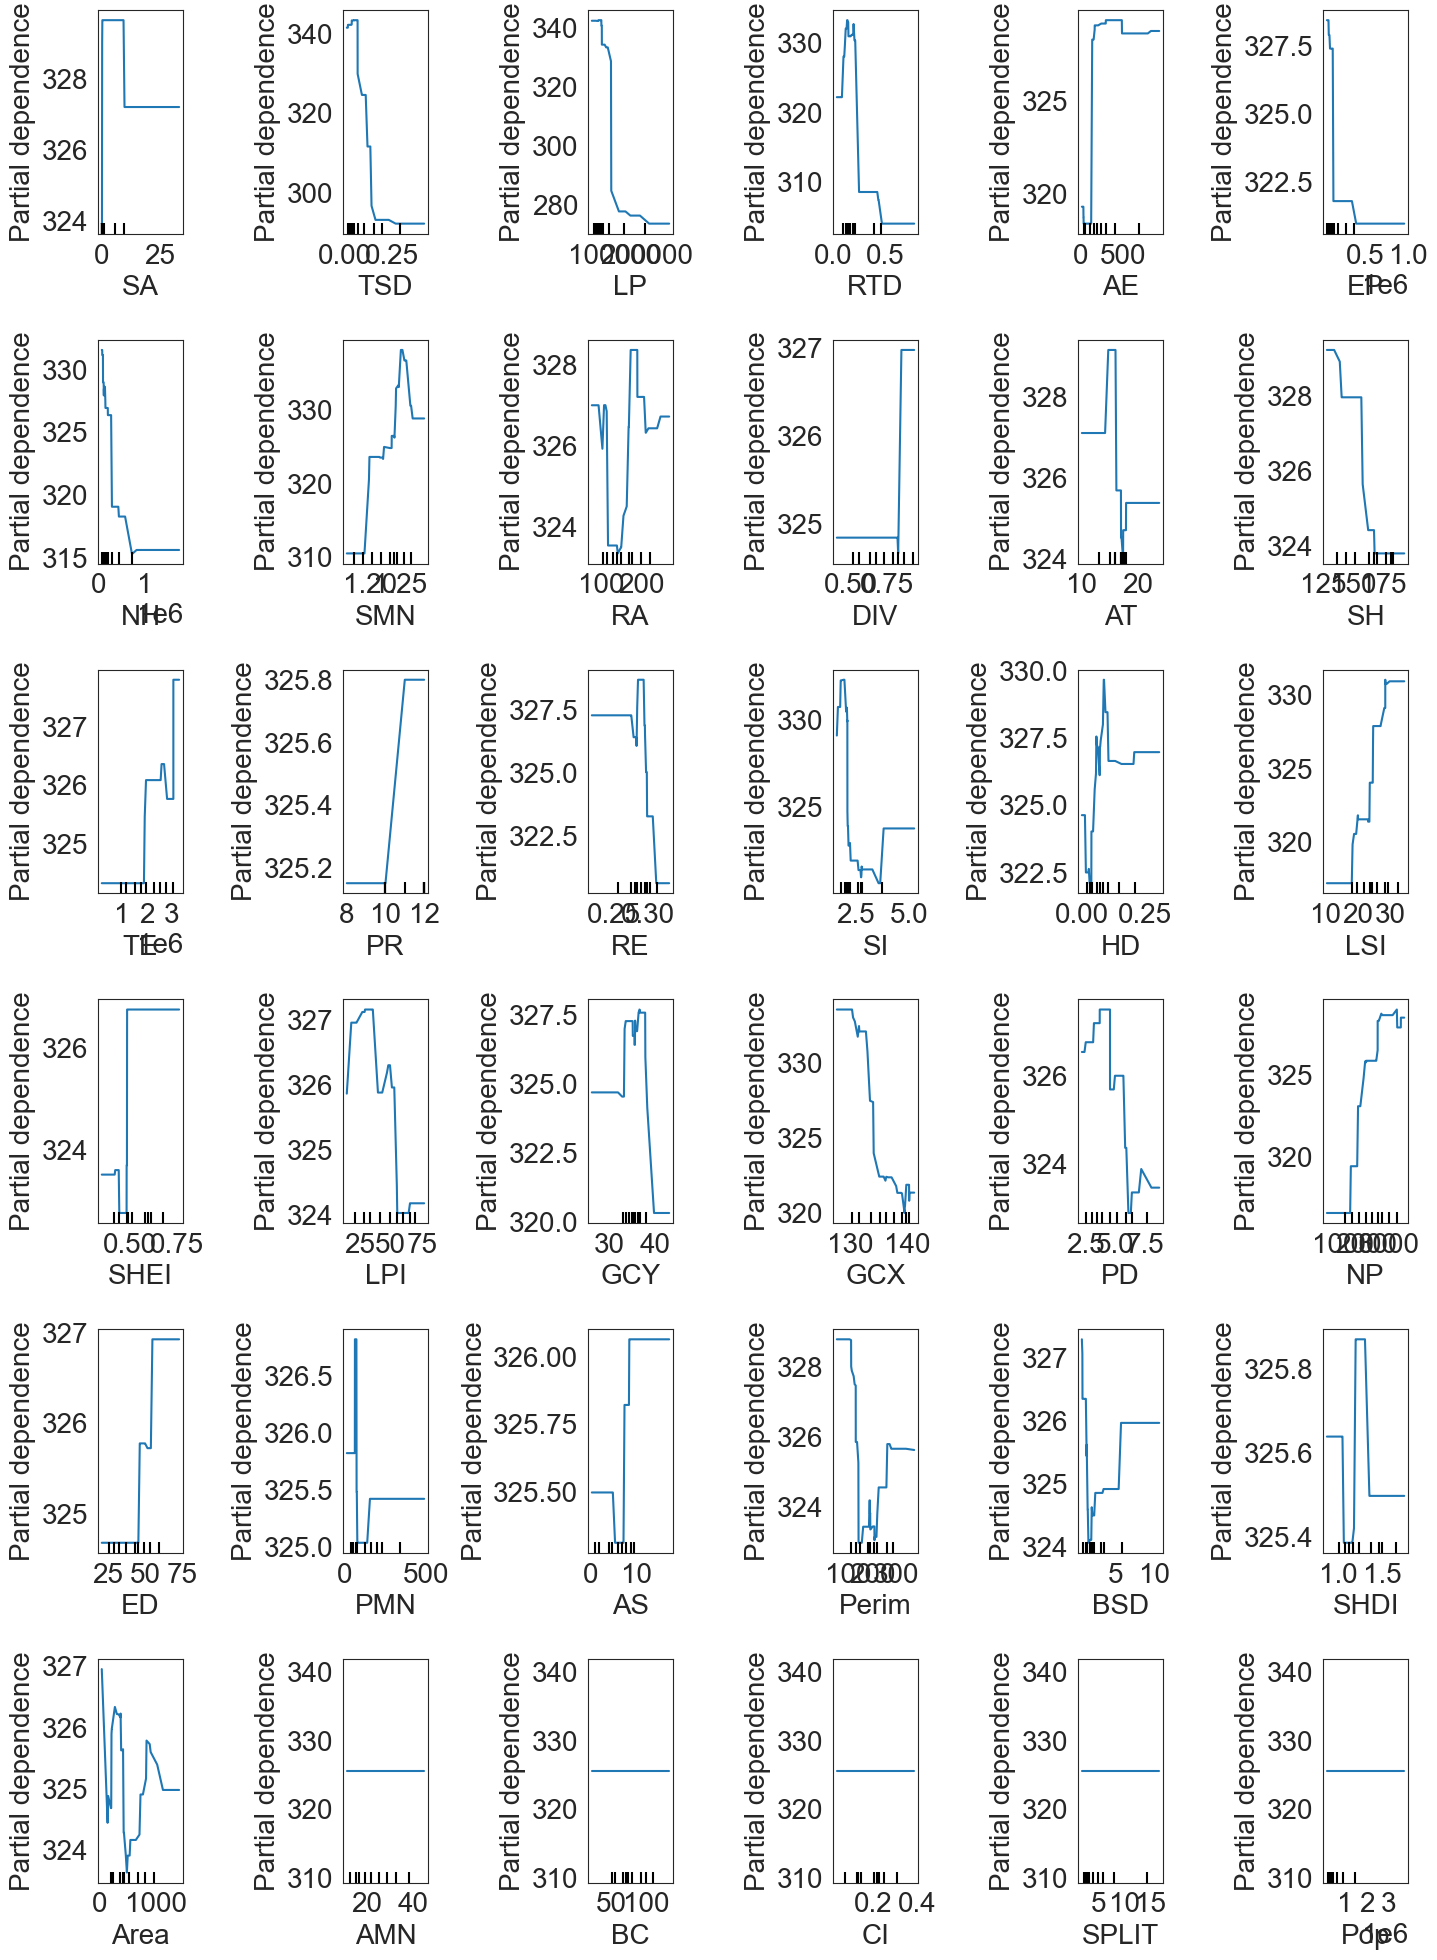

In [12]:
#XGBoost
# ─────────────────── 2. 超参数调优：GridSearchCV ───────────────────
param_grid = {
    'n_estimators':    [100, 200, 500],
    'learning_rate':   [0.01, 0.1, 0.2],
    'max_depth':       [3, 5, 7],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'reg_lambda':      [0.1, 1, 5]
}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=0, verbosity=0)

grid = GridSearchCV(
    xgb_base,
    param_grid,
    cv        = inner_cv,
    scoring   = 'neg_root_mean_squared_error',
    n_jobs    = -1,
    verbose   = 1
)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
print("\nBest hyper-parameters:", grid.best_params_)

# CV RMSE mean ± std
cv_scores = -grid.cv_results_['mean_test_score']
cv_std    =  grid.cv_results_['std_test_score'][grid.best_index_]
print(f"5-fold CV RMSE = {cv_scores.mean():.2f} ± {cv_std:.2f}")

# ─────────────────── 3. 过拟合检查：训练 vs 测试 ───────────────────
y_pred_tr = best_xgb.predict(X_train)
y_pred_te = best_xgb.predict(X_test)

print("\nXGBoost Training dataset:")
print(f" R²:   {r2_score(y_train, y_pred_tr):.3f}")
print(f" RMSE: {mean_squared_error(y_train, y_pred_tr, squared=False):.2f}")
print(f" MAE:  {mean_absolute_error(y_train, y_pred_tr):.2f}")

print("\nXGBoost Testing dataset:")
print(f" R²:   {r2_score(y_test, y_pred_te):.3f}")
print(f" RMSE: {mean_squared_error(y_test, y_pred_te, squared=False):.2f}")
print(f" MAE:  {mean_absolute_error(y_test, y_pred_te):.2f}")

# ─────────────────── 4. 特征重要性排名 ───────────────────
importances = best_xgb.feature_importances_
feat_list  = X.columns.tolist()
imp_series = pd.Series(importances, index=feat_list).sort_values(ascending=False)

print("\nTop 10 important features:\n", imp_series.head(10))

# ─────────────────── 5. SHAP summary plot ───────────────────
explainer   = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)  # 用测试集更能反映泛化

# 绘制 & 保存
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.svg", format="svg", bbox_inches="tight")
plt.close()

# ─────────────────── 6. Partial Dependence Plots ───────────────────
top_feats = imp_series.head(36).index  # 前36个
fig, axs = plt.subplots(6, 6, figsize=(15, 20))
axs = axs.ravel()

for i, feat in enumerate(top_feats):
    PartialDependenceDisplay.from_estimator(
        best_xgb,
        X_train,
        features=[feat],
        ax=axs[i],
        feature_names=X_train.columns,
        grid_resolution=50
    )

for j in range(len(top_feats), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("pdp_xgb.svg", format="svg", bbox_inches="tight")
plt.show()


In [13]:
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# ─────────────────── 2. 超参数调优：GridSearchCV ───────────────────
param_grid = {
    'C':       [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel':  ['rbf']
}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
svr_base = SVR()

grid_svr = GridSearchCV(
    estimator  = svr_base,
    param_grid = param_grid,
    cv         = inner_cv,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = -1,
    verbose    = 1
)

grid_svr.fit(X_train, y_train)
best_svr = grid_svr.best_estimator_

# 打印最优超参数
print("Best SVR parameters:", grid_svr.best_params_)

# 5-fold CV RMSE (mean ± std)
cv_scores = -grid_svr.cv_results_['mean_test_score']
cv_std    =  grid_svr.cv_results_['std_test_score'][grid_svr.best_index_]
print(f"5-fold CV RMSE = {cv_scores.mean():.2f} ± {cv_std:.2f}")

# ─────────────────── 3. 过拟合评估：训练 vs 测试 ───────────────────
y_train_pred = best_svr.predict(X_train)
y_test_pred  = best_svr.predict(X_test)

print("\nSVR Training set performance:")
print(f" R² : {r2_score(y_train, y_train_pred):.3f}")
print(f" RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.2f}")
print(f" MAE : {mean_absolute_error(y_train, y_train_pred):.2f}")

print("\nSVR Testing set performance:")
print(f" R² : {r2_score(y_test, y_test_pred):.3f}")
print(f" RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.2f}")
print(f" MAE : {mean_absolute_error(y_test, y_test_pred):.2f}")



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVR parameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
5-fold CV RMSE = 87.09 ± 15.56

SVR Training set performance:
 R² : 0.656
 RMSE: 53.33
 MAE : 39.23

SVR Testing set performance:
 R² : 0.361
 RMSE: 63.01
 MAE : 56.98


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
